# Calculates area and intensity for all cells for all markers 
Outputs boxplots

In [1]:
import os
import glob
import sys
from pathlib import Path 
from math import log10, sqrt, ceil, floor, log, exp, pi, isnan
import numpy as np
import numpy.ma as ma
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.patches as mpatches
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm
fontprops = fm.FontProperties(size=30)
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cmapy
import tifffile
import pandas as pd
from ast import literal_eval
import cv2
from PIL import Image
from PIL import ImageTk
from scipy import fftpack
from scipy import ndimage
from scipy import stats
from scipy.spatial import distance
from scipy.cluster import hierarchy
from scipy.signal import convolve2d
import seaborn as sns
from tqdm.notebook import tqdm, trange
from skimage import color
from sklearn.preprocessing import RobustScaler, StandardScaler
import skimage.filters as skf
from skimage.filters import laplace, threshold_otsu
import skimage.exposure as ske
from skimage.transform import rescale
from skimage.util import view_as_windows
from skimage.feature import canny
from skimage.metrics import mean_squared_error as mse
from skimage.metrics import structural_similarity as ssim
from statannot import add_stat_annotation
import scipy
import pickle
import time

import multiprocessing as mp
from multiprocessing import Process, Queue, Value, Array, Pool

import matplotlib.font_manager as fm
%matplotlib inline
%gui qt5

In [2]:
# # Import path
# module_path = str(Path.cwd().parents[0])
# if module_path not in sys.path:
#     sys.path.append(module_path)

# module_path = str(Path.cwd().parents[0] / "src")
# if module_path not in sys.path:
#     sys.path.append(module_path)

In [3]:
os.chdir('..')
os.chdir('./src')

In [4]:
from my_io import display_list_image, read_tiff_files
from config import *

In [5]:
# Figures location    
save_path = f"{data_figure}/boxplots/"
if not os.path.exists(save_path):
    os.makedirs(save_path)

### Load the datasets

In [6]:
pickle_name_temp = f"{data_path_masked_BM}/image_list_BM.pickle"
zoomed_image_list_BM = pickle.load(open(pickle_name_temp, "rb"))

pickle_name_temp = f"{data_path_masked_UC}/image_list_UC.pickle"
zoomed_image_list_UC = pickle.load(open(pickle_name_temp, "rb"))

In [7]:
pickle_name_temp = f"{data_path_masked_BM}/mask_list_BM.pickle"
zoomed_mask_BM = pickle.load(open(pickle_name_temp, "rb"))

pickle_name_temp = f"{data_path_masked_UC}/mask_list_UC.pickle"
zoomed_mask_UC = pickle.load(open(pickle_name_temp, "rb"))

In [8]:
df_path = data_dir / "BM_UC_indices_all.csv"
df_indices = pd.read_csv(df_path)

In [9]:
df_BM = df_indices.loc[df_indices['CellType']=='BM']
df_BM = df_BM.fillna('')
cellList_BM = []
for index, row in df_BM.iterrows(): 
    templist = []
    if row.indices!='':
        templist.append(literal_eval(row.indices))
        cellList_BM.append(list(templist[0]))
    else:
        cellList_BM.append(templist)

In [10]:
df_UC = df_indices.loc[df_indices['CellType']=='UC']
df_UC = df_UC.fillna('')
cellList_UC = []
for index, row in df_UC.iterrows(): 
    templist = []
    if row.indices!='':
        templist.append(literal_eval(row.indices))
        cellList_UC.append(list(templist[0]))
    else:
        cellList_UC.append(templist)

### Function to calculate area and intensity

In [11]:
def calculate_area_intensity(image_cell):
    marker_temp = (image_cell).astype(np.uint8)
    kernel_open = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(9,9))
    kernel_close = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(11,11))
    
    ret,thresh_temp = cv2.threshold(marker_temp,0,255,cv2.THRESH_OTSU) # otsu thresholding
    opening_temp = cv2.morphologyEx(thresh_temp, cv2.MORPH_OPEN, kernel_open)
    closing_temp = cv2.morphologyEx(opening_temp, cv2.MORPH_CLOSE, kernel_close)
    area_temp = closing_temp.ravel().sum() / 255
    closing_img_temp = (closing_temp.copy().astype(np.float64) / 255) * image_cell
    intensity_mean = closing_img_temp.mean()
    return area_temp, intensity_mean

### Area boxplot

In [12]:
areaDict_BM = {}
intensityDict_BM = {}
for cell in trange(len(cellList_BM)):
    for entry in cellList_BM[cell]:
        mask_temp = zoomed_mask_BM[cell].copy()
        area_temp, intensity_temp = calculate_area_intensity(mask_temp)
        dictKey = channel_names[entry]
        if not dictKey in areaDict_BM.keys():
            areaDict_BM[dictKey] = []
        if not dictKey in intensityDict_BM.keys():
            intensityDict_BM[dictKey] = []
        areaDict_BM[dictKey].append(area_temp)
        intensityDict_BM[dictKey].append(intensity_temp)

  0%|          | 0/32 [00:00<?, ?it/s]

In [13]:
areaDict_UC = {}
intensityDict_UC = {}
for cell in trange(len(cellList_UC)):
    for entry in cellList_UC[cell]:
        mask_temp = zoomed_mask_UC[cell].copy()
        area_temp, intensity_temp = calculate_area_intensity(mask_temp)
        dictKey = channel_names[entry]
        if not dictKey in areaDict_UC.keys():
            areaDict_UC[dictKey] = []
        if not dictKey in intensityDict_UC.keys():
            intensityDict_UC[dictKey] = []
        areaDict_UC[dictKey].append(area_temp)
        intensityDict_UC[dictKey].append(intensity_temp)

  0%|          | 0/35 [00:00<?, ?it/s]

In [14]:
area_df_BM = pd.DataFrame.from_dict(areaDict_BM.items())
area_df_BM.columns = ['Marker', 'Area']
area_df_BM['Cell Type'] = 'BM'

In [15]:
area_df_UC = pd.DataFrame.from_dict(areaDict_UC.items())
area_df_UC.columns = ['Marker', 'Area']
area_df_UC['Cell Type'] = 'UC'

In [16]:
area_df = pd.concat([area_df_BM, area_df_UC])
area_df = area_df.explode('Area')
area_df = area_df.sort_values(by=['Marker'])

In [17]:
area_df

,Marker,Area,Cell Type
0,ATF6,101292.0,BM
0,ATF6,424409.0,UC
0,ATF6,590015.0,UC
0,ATF6,256888.0,UC
0,ATF6,473796.0,UC
...,...,...,...
10,WGA,303619.0,BM
10,WGA,155642.0,BM
10,WGA,338642.0,BM
10,WGA,299897.0,BM


In [18]:
area_df['Area'] = area_df['Area'].values.astype(float)
area_df.groupby(["Marker","Cell Type"]).agg({'Area': ['min', 'mean', 'median', 'max']}).to_csv("temp_area.csv")

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

TOM20_BM v.s. TOM20_UC: Mann-Whitney-Wilcoxon test two-sided, P_val=1.740e-01 U_stat=9.100e+01
WGA_BM v.s. WGA_UC: Mann-Whitney-Wilcoxon test two-sided, P_val=4.845e-01 U_stat=2.700e+01
Sortilin_BM v.s. Sortilin_UC: Mann-Whitney-Wilcoxon test two-sided, P_val=1.017e-01 U_stat=6.700e+01
BetaTubulin_BM v.s. BetaTubulin_UC: Mann-Whitney-Wilcoxon test two-sided, P_val=8.532e-02 U_stat=5.700e+01
ATF6_BM v.s. ATF6_UC: Mann-Whitney-Wilcoxon test two-sided, P_val=7.130e-02 U_stat=9.000e+01
ConcanavalinA_BM v.s. ConcanavalinA_UC: Mann-Whitney-Wilcoxon test two-sided, P_val=8.252e-01 U_stat=2.000e+01
DAPI_BM v.s. DAPI_UC: Mann-Whitney-Wilcoxon test two-sided, P_val=1.146e-01 U_stat=1.490e+02
GOLPH4_BM v.s. GOLPH4_UC: Mann-Whitney-Wilcoxon test two-sided, P_val=1.708e-01 U_stat=1.110e+02
HSP60_BM v.s. HSP60_UC: Mann-Whitney-Wilcoxon te

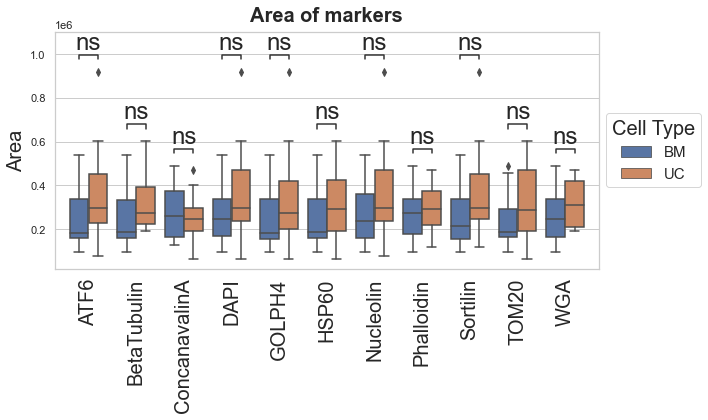

In [19]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))
plt.title('Area of markers')

data = area_df
x = "Marker"
y = "Area"
hue = "Cell Type"
hue_order=['BM', 'UC']
channels = data["Marker"].unique()
box_pairs=[((chan, "BM"), (chan, "UC")) for chan in channels]

g = sns.boxplot(data=data, hue=hue, x=x, y=y)

ax, stats = add_stat_annotation(g, data=data, x=x, y=y, hue=hue, box_pairs=box_pairs,
                    test='Mann-Whitney', loc='inside', verbose=2, comparisons_correction=None, fontsize = 24)
g.figure.axes[-1].yaxis.label.set_size(20)
g.set_xticklabels(g.get_xmajorticklabels(), fontsize = 20, rotation=90)
# g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 20)
g.set_title(f"Area of markers",fontsize= 20, pad=10, fontweight ="bold")
g.set_xlabel("",fontsize=1)
g.set_ylabel("Area",fontsize=20)
handles, labels = g.get_legend_handles_labels()
g.legend(handles[:2], labels[:2], title='Cell Type', fontsize=15, title_fontsize=20, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
image_path_png = save_path+"/area_BM_UC.png"
plt.savefig(image_path_png, bbox_inches="tight")
plt.show()

tbl = pd.DataFrame()
# format table for supplementary
data = data.groupby(['Cell Type', "Marker"]).agg({'Area': ['min', 'mean', 'median', 'max']})
# concat BM and UC
data_BM = data.loc[data.index.get_level_values(0) == 'BM']
data_BM = data_BM.droplevel(0)
data_BM.columns = ['_'.join(pair) + '_BM' for pair in data_BM.columns]

data_UC = data.loc[data.index.get_level_values(0) == 'UC']
data_UC = data_UC.droplevel(0)
data_UC.columns = ['_'.join(pair) + '_UC' for pair in data_UC.columns]

data = pd.concat([data_BM, data_UC], axis = 1)

# add stats test results
dfStat = pd.DataFrame()
for jj, stat in enumerate(stats): # each stat result
    res = stat.__dict__
    markerComp = res['box1'][0]
    pval = res['pval']
    uStat = res['stat']

    dfSub = {'Marker': markerComp, 
            'P_val': pval,
            'U_stat': uStat}
    dfSub = pd.DataFrame(dfSub, index = [0])
    dfStat = pd.concat([dfStat, dfSub])

dfStat.set_index('Marker', inplace = True)

# merge stats 
data = data.merge(dfStat, how = 'outer', left_index = True, right_index = True)
    
tbl = pd.concat([tbl, data]) # ordered by group
            
tbl.reset_index(drop = False, inplace = True)
# export table to excel
fileOut = os.path.join(save_path, 'area_table.xlsx')
tbl.to_excel(fileOut)

### Intensity boxplot

In [20]:
intensity_df_BM = pd.DataFrame.from_dict(intensityDict_BM.items())
intensity_df_BM.columns = ['Marker', 'Intensity']
intensity_df_BM['Cell Type'] = 'BM'

In [21]:
intensity_df_UC = pd.DataFrame.from_dict(intensityDict_UC.items())
intensity_df_UC.columns = ['Marker', 'Intensity']
intensity_df_UC['Cell Type'] = 'UC'

In [22]:
intensity_df = pd.concat([intensity_df_BM, intensity_df_UC])
intensity_df = intensity_df.explode('Intensity')
intensity_df = intensity_df.sort_values(by=['Marker'])

In [23]:
intensity_df['Intensity'] = intensity_df['Intensity'].values.astype(float)
intensity_df.groupby(["Marker","Cell Type"]).agg({'Intensity': ['min', 'mean', 'median', 'max']}).to_csv("temp_Intensity.csv")

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

TOM20_BM v.s. TOM20_UC: Mann-Whitney-Wilcoxon test two-sided, P_val=7.626e-01 U_stat=1.360e+02
WGA_BM v.s. WGA_UC: Mann-Whitney-Wilcoxon test two-sided, P_val=3.420e-01 U_stat=4.800e+01
Sortilin_BM v.s. Sortilin_UC: Mann-Whitney-Wilcoxon test two-sided, P_val=7.434e-01 U_stat=1.130e+02
BetaTubulin_BM v.s. BetaTubulin_UC: Mann-Whitney-Wilcoxon test two-sided, P_val=8.008e-01 U_stat=8.900e+01
ATF6_BM v.s. ATF6_UC: Mann-Whitney-Wilcoxon test two-sided, P_val=3.315e-01 U_stat=1.710e+02
ConcanavalinA_BM v.s. ConcanavalinA_UC: Mann-Whitney-Wilcoxon test two-sided, P_val=2.601e-01 U_stat=2.600e+01
DAPI_BM v.s. DAPI_UC: Mann-Whitney-Wilcoxon test two-sided, P_val=7.053e-01 U_stat=2.250e+02
GOLPH4_BM v.s. GOLPH4_UC: Mann-Whitney-Wilcoxon test two-sided, P_val=4.987e-01 U_stat=1.740e+02
HSP60_BM v.s. HSP60_UC: Mann-Whitney-Wilcoxon te

C:\Users\NZHANG~1\AppData\Local\Temp/ipykernel_104724/2957502109.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 20)


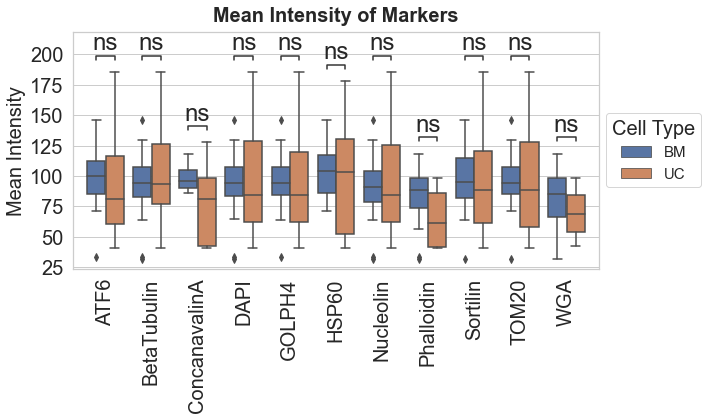

In [24]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))
plt.title('Intensity of markers')

data = intensity_df
x = "Marker"
y = "Intensity"
hue = "Cell Type"
hue_order=['BM', 'UC']
channels = data["Marker"].unique()
box_pairs=[((chan, "BM"), (chan, "UC")) for chan in channels]

g = sns.boxplot(data=data, hue=hue, x=x, y=y) #palette="Set3", 

add_stat_annotation(g, data=data, x=x, y=y, hue=hue, box_pairs=box_pairs,
                    test='Mann-Whitney', loc='inside', verbose=2, comparisons_correction=None, fontsize = 24)
g.figure.axes[-1].yaxis.label.set_size(20)
g.set_xticklabels(g.get_xmajorticklabels(), fontsize = 20, rotation=90)
g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 20)
g.set_title(f"Mean Intensity of Markers",fontsize= 20, pad=10, fontweight ="bold")
g.set_xlabel("",fontsize=1)
g.set_ylabel("Mean Intensity",fontsize=20)
handles, labels = g.get_legend_handles_labels()
g.legend(handles[:2], labels[:2], title='Cell Type', fontsize=15, title_fontsize=20, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
image_path_png = save_path+"/intensity_BM_UC.png"
plt.savefig(image_path_png, bbox_inches="tight")
plt.show()

tbl = pd.DataFrame()
# format table for supplementary
data = data.groupby(['Cell Type', "Marker"]).agg({'Intensity': ['min', 'mean', 'median', 'max']})
# concat BM and UC
data_BM = data.loc[data.index.get_level_values(0) == 'BM']
data_BM = data_BM.droplevel(0)
data_BM.columns = ['_'.join(pair) + '_BM' for pair in data_BM.columns]

data_UC = data.loc[data.index.get_level_values(0) == 'UC']
data_UC = data_UC.droplevel(0)
data_UC.columns = ['_'.join(pair) + '_UC' for pair in data_UC.columns]

data = pd.concat([data_BM, data_UC], axis = 1)

# add stats test results
dfStat = pd.DataFrame()
for jj, stat in enumerate(stats): # each stat result
    res = stat.__dict__
    markerComp = res['box1'][0]
    pval = res['pval']
    uStat = res['stat']

    dfSub = {'Marker': markerComp, 
            'P_val': pval,
            'U_stat': uStat}
    dfSub = pd.DataFrame(dfSub, index = [0])
    dfStat = pd.concat([dfStat, dfSub])

dfStat.set_index('Marker', inplace = True)

# merge stats 
data = data.merge(dfStat, how = 'outer', left_index = True, right_index = True)
    
tbl = pd.concat([tbl, data]) # ordered by group
            
tbl.reset_index(drop = False, inplace = True)
# export table to excel
fileOut = os.path.join(save_path, 'intensity_table.xlsx')
tbl.to_excel(fileOut)